In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler


class StandardScalerDf:
    
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, df):
        self.scaler.fit(df)
        
    def transform(self, df):
        df_ = self.scaler.transform(df)
        df_ = pd.DataFrame(df_, index=df.index, columns=df.columns)
        return df_


class LogitScalerStandardScaler:
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, df):
        df_ = np.log(df/(100 - df))
        self.scaler.fit(df_)
    
    def transform(self, df):
        df_ = np.log(df/(100 - df))
        df__ = self.scaler.transform(df_)
        df__ = pd.DataFrame(df__, index=df.index, columns=df.columns)
        return df__
    
    def inverse_transform(self, df__):
        df_ = self.scaler.inverse_transform(df__)
        df_ = pd.DataFrame(df_, index=df__.index, columns=df__.columns)
        #df = 100 * np.exp(df_)/(1 + np.exp(df_))
        df = 100 /(1 + np.exp(-df_))
        return df


class ZeroLogitOLSCV:
    
    def __init__(self, X_train, X_test, y_train, y_test, groups):
        self.X_train = X_train
        self.X_test = X_test
        
        self.y_train = y_train
        self.y_test = y_test
        
        self.groups = groups
        
        self.X_pp = StandardScalerDf()
        self.X_pp.fit(self.X_train)
        self.X_train_ = self.X_pp.transform(self.X_train)
        self.X_test_ = self.X_pp.transform(self.X_test)
        
        self.y_pp = LogitScalerStandardScaler()
        self.y_pp.fit(self.y_train)
        self.y_train_ = self.y_pp.transform(self.y_train)
        self.y_test_ = self.y_pp.transform(self.y_test)
        
        self.model_ = LinearRegression()
        
        self.y_pred_train_ = None
        self.y_pred_test_ = None
        
        self.y_pred_train = None
        self.y_pred_test = None
        
    def fit(self):
        self.model_.fit(self.X_train_, self.y_train_)
        
    def predict(self):
        y_pred_train_ = self.model_.predict(self.X_train_)
        self.y_pred_train_ = pd.DataFrame(y_pred_train_, index=self.y_train_.index, columns=self.y_train_.columns)
        y_pred_test_ = self.model_.predict(self.X_test_)
        self.y_pred_test_ = pd.DataFrame(y_pred_test_, index=self.y_test_.index, columns=self.y_test_.columns)
        self.y_pred_train = self.y_pp.inverse_transform(self.y_pred_train_)
        self.y_pred_test = self.y_pp.inverse_transform(self.y_pred_test_)


In [2]:
from collections import defaultdict


X_path = "./X.csv"
X = pd.read_csv(X_path, index_col=["backbone", "pyridone"])
X = X.sub(X["0"], axis=0)
X = X.drop("0", axis=1)
display(X)

y_path = "./y.csv"
y = pd.read_csv(y_path, index_col=["backbone", "pyridone"])
display(y)

logo = LeaveOneGroupOut()
groups_outer = X.index.get_level_values("pyridone")
models = defaultdict(dict)

for i, (index_train, index_test) in enumerate(logo.split(X, y, groups_outer)):
    print(f"--- split={i} ---")
    columns = X.columns
    
    for n_features in range(len(columns), 4, -1):
        print(f"--- n_features={n_features} ---")
        X_train = X.iloc[index_train][columns]
        X_test = X.iloc[index_test][columns]
        y_train = y.iloc[index_train]
        y_test = y.iloc[index_test]
        groups_inner = X_train.index.get_level_values("pyridone")
        
        model = ZeroLogitOLSCV(X_train, X_test, y_train, y_test, groups_inner)
        model.fit()
        model.predict()
        models[X_test.index.get_level_values("pyridone")[0]][n_features] = model
        
        coef_df = pd.DataFrame(model.model_.coef_.reshape(1, -1), index=["coef"], columns=columns)
        columns_min = coef_df.abs().idxmin(axis=1)
        columns = columns.drop(columns_min)
        

2         3         4         6         7         9  \
backbone pyridone                                                               
0        0        -0.008695 -0.057056 -0.008886 -0.026198 -0.041120  0.032579   
         1        -0.008695 -0.052599 -0.008886 -0.021780 -0.036864  0.032579   
         2        -0.008695 -0.054448 -0.008886 -0.023546 -0.038881  0.032579   
         3        -0.008695 -0.052436 -0.008886 -0.022054 -0.037311  0.032579   
         4        -0.008695 -0.053723 -0.008886 -0.025236 -0.039595  0.032579   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.008767 -0.046001 -0.008959 -0.024819 -0.038401  0.032447   
         9        -0.008767 -0.057810 -0.008959 -0.029390 -0.042452  0.032447   
         10       -0.008767 -0.046827 -0.008959 -0.026338 -0.039197  0.032447   
         11       -0.008767 -0.047412 -0.008959 -0.027697 -0.039272  0.032447   
         12       -0.008767 -0.056018 -0.008959 -0.026983 -0.040581  0.032447   

                         12        14        16        18  ...       507  \
backbone pyridone                                          ...             
0        0        -0.050338 -0.056655 -0.064589 -0.059825  ... -0.094124   
         1        -0.050736 -0.053830 -0.064255 -0.062201  ... -0.091687   
         2        -0.052990 -0.055201 -0.064532 -0.060393  ... -0.093373   
         3        -0.054012 -0.054275 -0.065711 -0.061291  ... -0.093179   
         4        -0.053024 -0.055508 -0.065862 -0.060430  ... -0.094225   
...                     ...       ...       ...       ...  ...       ...   
20       8        -0.047765 -0.056455 -0.062096 -0.060130  ... -0.091707   
         9        -0.053905 -0.055819 -0.067570 -0.058327  ... -0.094560   
         10       -0.049379 -0.056267 -0.064423 -0.059175  ... -0.091984   
         11       -0.053060 -0.056908 -0.067281 -0.056894  ... -0.092795   
         12       -0.051470 -0.054585 -0.066968 -0.060803  ... -0.092563   

                        519       538       540       543       575       597  \
backbone pyridone                                                               
0        0        -0.099624 -0.089446 -0.090086 -0.084177 -0.093292 -0.091567   
         1        -0.096809 -0.087070 -0.088095 -0.082335 -0.090797 -0.089023   
         2        -0.099589 -0.087857 -0.089579 -0.082563 -0.092372 -0.089866   
         3        -0.097998 -0.087177 -0.089471 -0.084803 -0.094709 -0.088976   
         4        -0.099139 -0.088837 -0.089840 -0.083402 -0.092848 -0.090779   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.093021 -0.084357 -0.088355 -0.081076 -0.090303 -0.081064   
         9        -0.102201 -0.088485 -0.091040 -0.083632 -0.092650 -0.085170   
         10       -0.094866 -0.084769 -0.089273 -0.082601 -0.090553 -0.081496   
         11       -0.095046 -0.083823 -0.090071 -0.081768 -0.091257 -0.081348   
         12       -0.100542 -0.087970 -0.088658 -0.082708 -0.090361 -0.084223   

                        602       605       642  
backbone pyridone                                
0        0        -0.079205 -0.087926 -0.089446  
         1        -0.075984 -0.085548 -0.087070  
         2        -0.078479 -0.086393 -0.087857  
         3        -0.078163 -0.085580 -0.087177  
         4        -0.078987 -0.087082 -0.088837  
...                     ...       ...       ...  
20       8        -0.073291 -0.083268 -0.083104  
         9        -0.079348 -0.087811 -0.088484  
         10       -0.074080 -0.083599 -0.083851  
         11       -0.074368 -0.083447 -0.083823  
         12       -0.076616 -0.086800 -0.087970  

[104 rows x 51 columns]

beta_av
backbone pyridone           
0        0         51.388357
         1         63.841924
         2         59.085161
         3         53.059721
         4         53.917807
...                      ...
20       8         19.228094
         9         24.595903
         10        21.060263
         11        19.203989
         12        23.601443

[104 rows x 1 columns]

--- split=0 ---
--- n_features=51 ---
--- n_features=50 ---
--- n_features=49 ---
--- n_features=48 ---
--- n_features=47 ---
--- n_features=46 ---
--- n_features=45 ---
--- n_features=44 ---
--- n_features=43 ---
--- n_features=42 ---
--- n_features=41 ---
--- n_features=40 ---
--- n_features=39 ---
--- n_features=38 ---
--- n_features=37 ---
--- n_features=36 ---
--- n_features=35 ---
--- n_features=34 ---
--- n_features=33 ---
--- n_features=32 ---
--- n_features=31 ---
--- n_features=30 ---
--- n_features=29 ---
--- n_features=28 ---
--- n_features=27 ---
--- n_features=26 ---
--- n_features=25 ---
--- n_features=24 ---
--- n_features=23 ---
--- n_features=22 ---
--- n_features=21 ---
--- n_features=20 ---
--- n_features=19 ---
--- n_features=18 ---
--- n_features=17 ---
--- n_features=16 ---
--- n_features=15 ---
--- n_features=14 ---
--- n_features=13 ---
--- n_features=12 ---
--- n_features=11 ---
--- n_features=10 ---
--- n_features=9 ---
--- n_features=8 ---
--- n_features=7 -

--- n_features=50 ---
--- n_features=49 ---
--- n_features=48 ---
--- n_features=47 ---
--- n_features=46 ---
--- n_features=45 ---
--- n_features=44 ---
--- n_features=43 ---
--- n_features=42 ---
--- n_features=41 ---
--- n_features=40 ---
--- n_features=39 ---
--- n_features=38 ---
--- n_features=37 ---
--- n_features=36 ---
--- n_features=35 ---
--- n_features=34 ---
--- n_features=33 ---
--- n_features=32 ---
--- n_features=31 ---
--- n_features=30 ---
--- n_features=29 ---
--- n_features=28 ---
--- n_features=27 ---
--- n_features=26 ---
--- n_features=25 ---
--- n_features=24 ---
--- n_features=23 ---
--- n_features=22 ---
--- n_features=21 ---
--- n_features=20 ---
--- n_features=19 ---
--- n_features=18 ---
--- n_features=17 ---
--- n_features=16 ---
--- n_features=15 ---
--- n_features=14 ---
--- n_features=13 ---
--- n_features=12 ---
--- n_features=11 ---
--- n_features=10 ---
--- n_features=9 ---
--- n_features=8 ---
--- n_features=7 ---
--- n_features=6 ---
--- n_features

In [3]:
models_df = pd.DataFrame.from_dict(models).T
display(models_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
0,<__main__.ZeroLogitOLSCV object at 0x159984250>,<__main__.ZeroLogitOLSCV object at 0x15b9a7850>,<__main__.ZeroLogitOLSCV object at 0x15b9adeb0>,<__main__.ZeroLogitOLSCV object at 0x15b9ba4c0>,<__main__.ZeroLogitOLSCV object at 0x15b9c0bb0>,<__main__.ZeroLogitOLSCV object at 0x15b9cb160>,<__main__.ZeroLogitOLSCV object at 0x15b9d2850>,<__main__.ZeroLogitOLSCV object at 0x15b9d7e20>,<__main__.ZeroLogitOLSCV object at 0x15b9e4520>,<__main__.ZeroLogitOLSCV object at 0x15b9eac10>,...,<__main__.ZeroLogitOLSCV object at 0x15bac8ca0>,<__main__.ZeroLogitOLSCV object at 0x15bad3340>,<__main__.ZeroLogitOLSCV object at 0x15bad8940>,<__main__.ZeroLogitOLSCV object at 0x15badef40>,<__main__.ZeroLogitOLSCV object at 0x15baea640>,<__main__.ZeroLogitOLSCV object at 0x15baf0c70>,<__main__.ZeroLogitOLSCV object at 0x15bafb2e0>,<__main__.ZeroLogitOLSCV object at 0x15bb03910>,<__main__.ZeroLogitOLSCV object at 0x15bb0c0d0>,<__main__.ZeroLogitOLSCV object at 0x15bb0a700>
1,<__main__.ZeroLogitOLSCV object at 0x15bb18be0>,<__main__.ZeroLogitOLSCV object at 0x15bb22250>,<__main__.ZeroLogitOLSCV object at 0x15bb27880>,<__main__.ZeroLogitOLSCV object at 0x15bb2ceb0>,<__main__.ZeroLogitOLSCV object at 0x15bb37520>,<__main__.ZeroLogitOLSCV object at 0x15bb3db50>,<__main__.ZeroLogitOLSCV object at 0x15bb481c0>,<__main__.ZeroLogitOLSCV object at 0x15bb4c820>,<__main__.ZeroLogitOLSCV object at 0x15bb50e50>,<__main__.ZeroLogitOLSCV object at 0x15bb5d4f0>,...,<__main__.ZeroLogitOLSCV object at 0x15bc31610>,<__main__.ZeroLogitOLSCV object at 0x15bc35c40>,<__main__.ZeroLogitOLSCV object at 0x15bc42340>,<__main__.ZeroLogitOLSCV object at 0x15bc46970>,<__main__.ZeroLogitOLSCV object at 0x15bc4dfa0>,<__main__.ZeroLogitOLSCV object at 0x15bc57610>,<__main__.ZeroLogitOLSCV object at 0x15bc5cd90>,<__main__.ZeroLogitOLSCV object at 0x15bc66640>,<__main__.ZeroLogitOLSCV object at 0x15bc6dca0>,<__main__.ZeroLogitOLSCV object at 0x15bc74460>
2,<__main__.ZeroLogitOLSCV object at 0x15bc76b50>,<__main__.ZeroLogitOLSCV object at 0x15bc7dbe0>,<__main__.ZeroLogitOLSCV object at 0x15bc84250>,<__main__.ZeroLogitOLSCV object at 0x15bc88820>,<__main__.ZeroLogitOLSCV object at 0x15bc8be50>,<__main__.ZeroLogitOLSCV object at 0x15bc944f0>,<__main__.ZeroLogitOLSCV object at 0x15bc96b20>,<__main__.ZeroLogitOLSCV object at 0x15bc9e190>,<__main__.ZeroLogitOLSCV object at 0x15bca27c0>,<__main__.ZeroLogitOLSCV object at 0x15bca6eb0>,...,<__main__.ZeroLogitOLSCV object at 0x15bd81f10>,<__main__.ZeroLogitOLSCV object at 0x15bd8d580>,<__main__.ZeroLogitOLSCV object at 0x15bd92bb0>,<__main__.ZeroLogitOLSCV object at 0x15bd9e220>,<__main__.ZeroLogitOLSCV object at 0x15bda4850>,<__main__.ZeroLogitOLSCV object at 0x15bdaae80>,<__main__.ZeroLogitOLSCV object at 0x15bdb84f0>,<__main__.ZeroLogitOLSCV object at 0x15bdbcb20>,<__main__.ZeroLogitOLSCV object at 0x15bdc7430>,<__main__.ZeroLogitOLSCV object at 0x15bdcd850>
3,<__main__.ZeroLogitOLSCV object at 0x15bdd2eb0>,<__main__.ZeroLogitOLSCV object at 0x15bddc400>,<__main__.ZeroLogitOLSCV object at 0x15bde3a60>,<__main__.ZeroLogitOLSCV object at 0x15bded0d0>,<__main__.ZeroLogitOLSCV object at 0x15bdf6700>,<__main__.ZeroLogitOLSCV object at 0x15bdfad30>,<__main__.ZeroLogitOLSCV object at 0x15be05310>,<__main__.ZeroLogitOLSCV object at 0x15be079d0>,<__main__.ZeroLogitOLSCV object at 0x15be13f70>,<__main__.ZeroLogitOLSCV object at 0x15be1b670>,...,<__main__.ZeroLogitOLSCV object at 0x15bef8700>,<__main__.ZeroLogitOLSCV object at 0x15befed30>,<__main__.ZeroLogitOLSCV object at 0x15bf06370>,<__main__.ZeroLogitOLSCV object at 0x15bf0d970>,<__main__.ZeroLogitOLSCV object at 0x15bf18040>,<__main__.ZeroLogitOLSCV object at 0x15bf1c670>,<__main__.ZeroLogitOLSCV object at 0x15bf22ca0>,<__main__.ZeroLogitOLSCV object at 0x15bf2c310>,<__main__.ZeroLogitOLSCV object at 0x15bf33940>,<__main__.ZeroLogitOLSCV object at 0x15bf3c100>
4,<__main__.ZeroLogitOLSCV object at 0x15bf42970>,<__main__.ZeroLogitOLSCV o

In [4]:
import pickle


models_path = "./OLS_RFE_zero_models.pickle"

with open(models_path, "wb") as f:
    pickle.dump(models_df, f)
    

In [2]:
import pickle


models_path = "./OLS_RFE_zero_models.pickle"

with open(models_path, "rb") as f:
    models_df = pickle.load(f)
    

In [3]:
from sklearn.metrics import mean_squared_error


rmse_y_train_concat = {}
rmse_y_test_concat = {}

for column in models_df.columns:
    y_train_concat = pd.concat([model.y_train for model in models_df[column]])
    y_test_concat = pd.concat([model.y_test for model in models_df[column]])
    y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[column]])
    y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[column]])
    rmse_y_train_concat[column] = mean_squared_error(y_train_concat, y_pred_train_concat, squared=False)
    rmse_y_test_concat[column] = mean_squared_error(y_test_concat, y_pred_test_concat, squared=False)

rmse_concat_df = pd.DataFrame({"rmse_train": rmse_y_train_concat, "rmse_test": rmse_y_test_concat}).T
display(rmse_concat_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
rmse_train,2.911234,2.913593,2.913874,2.915464,2.919272,2.922385,2.927072,2.931923,2.934311,2.937356,...,4.085540,4.177784,4.296254,4.400562,4.589248,4.817366,5.103922,5.491768,6.077398,7.204432
rmse_test,20.887484,20.907277,20.900522,20.898621,20.832108,20.987574,20.885273,22.135096,20.744580,20.771418,...,14.657044,13.848438,13.780968,13.145425,12.900487,12.507565,12.851263,12.871252,13.791842,13.698775


In [4]:
import pickle


rmse_path = "./OLS_RFE_zero_RMSE.pickle"

with open(rmse_path, "wb") as f:
    pickle.dump(rmse_concat_df, f)
    

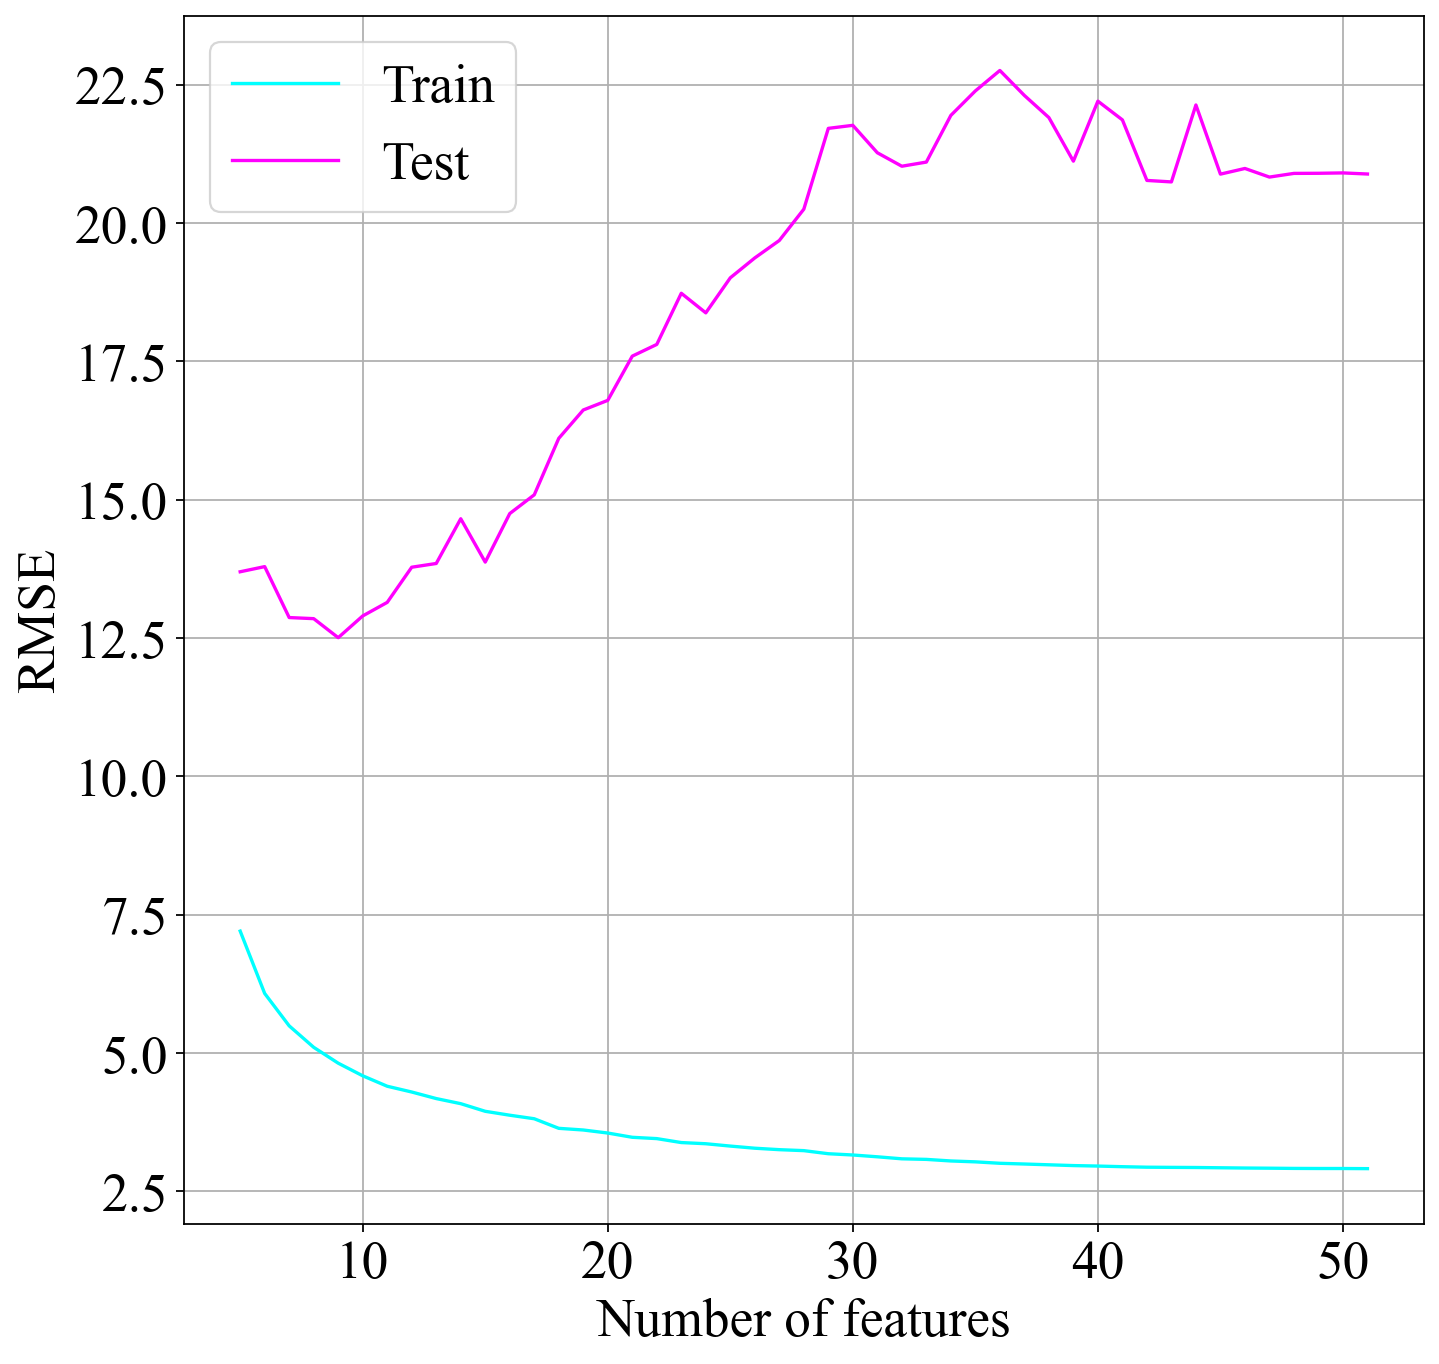

In [7]:
import matplotlib.pyplot as plt


plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Number of features")
ax.set_ylabel("RMSE")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_train"], color="cyan", label="Train")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_test"], color="magenta", label="Test")
ax.grid()
ax.legend()
plt.savefig("./OLS_RFE_zero_RMSE.png")
plt.show()


In [6]:
n_features_min = rmse_concat_df.loc["rmse_train"].idxmin()
print(n_features_min)

51


In [10]:
print(rmse_concat_df.at["rmse_test", n_features_min])

20.88748365478698


In [11]:
y_train_concat = pd.concat([model.y_train for model in models_df[n_features_min]])
y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[n_features_min]])
y_test_concat = pd.concat([model.y_test for model in models_df[n_features_min]])
y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[n_features_min]])


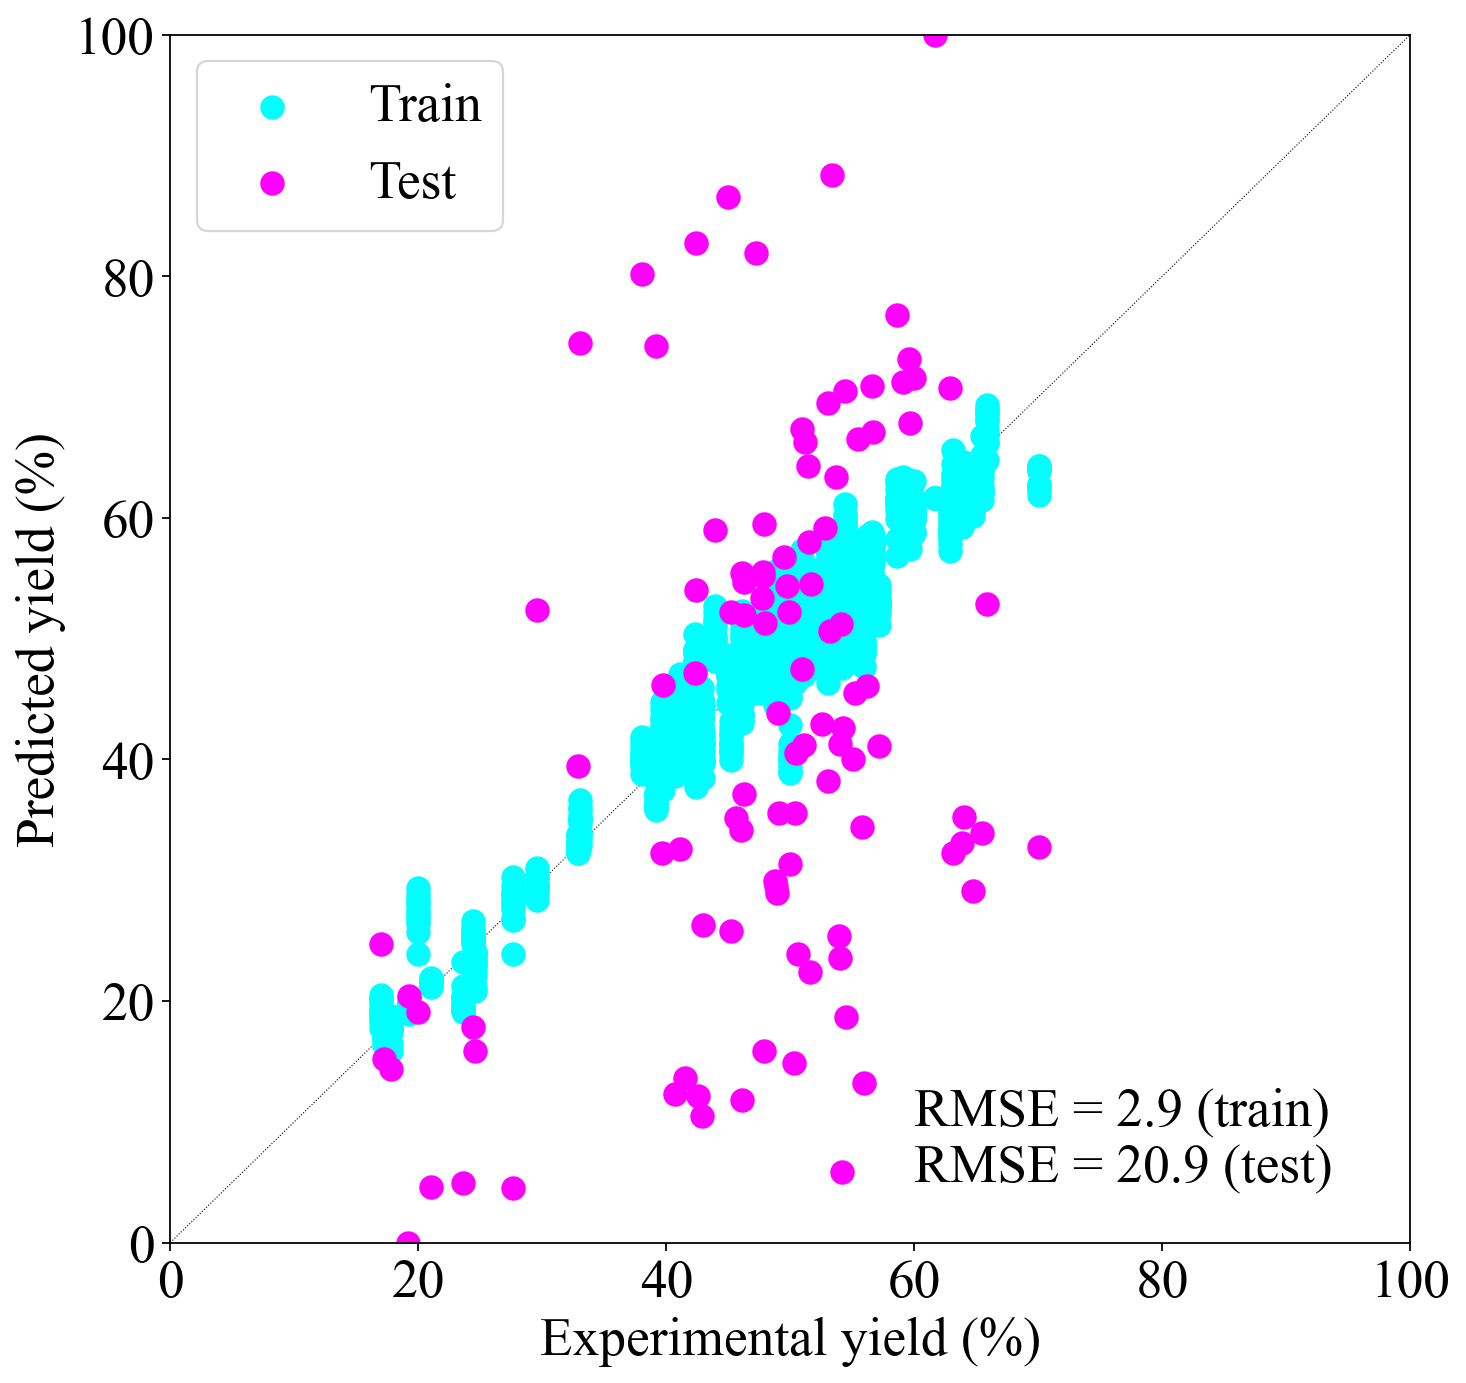

In [12]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Experimental yield (%)")
ax.set_ylabel("Predicted yield (%)")
ax.plot(
    [0, 100], [0, 100],
    color="black", linewidth=0.5, linestyle="dotted", zorder=0
)
ax.scatter(
    y_train_concat, y_pred_train_concat,
    color="cyan", s=100, label="Train", zorder=1
)
ax.scatter(
    y_test_concat, y_pred_test_concat,
    color="magenta", s=100, label="Test", zorder=2
)
ax.text(
    60, 5,
    f"RMSE = {mean_squared_error(y_train_concat, y_pred_train_concat, squared=False):1.1f} (train)\n"
    f"RMSE = {mean_squared_error(y_test_concat, y_pred_test_concat, squared=False):1.1f} (test)"
)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend()
plt.savefig("./OLS_RFE_zero_scatter_all.png")
plt.show()


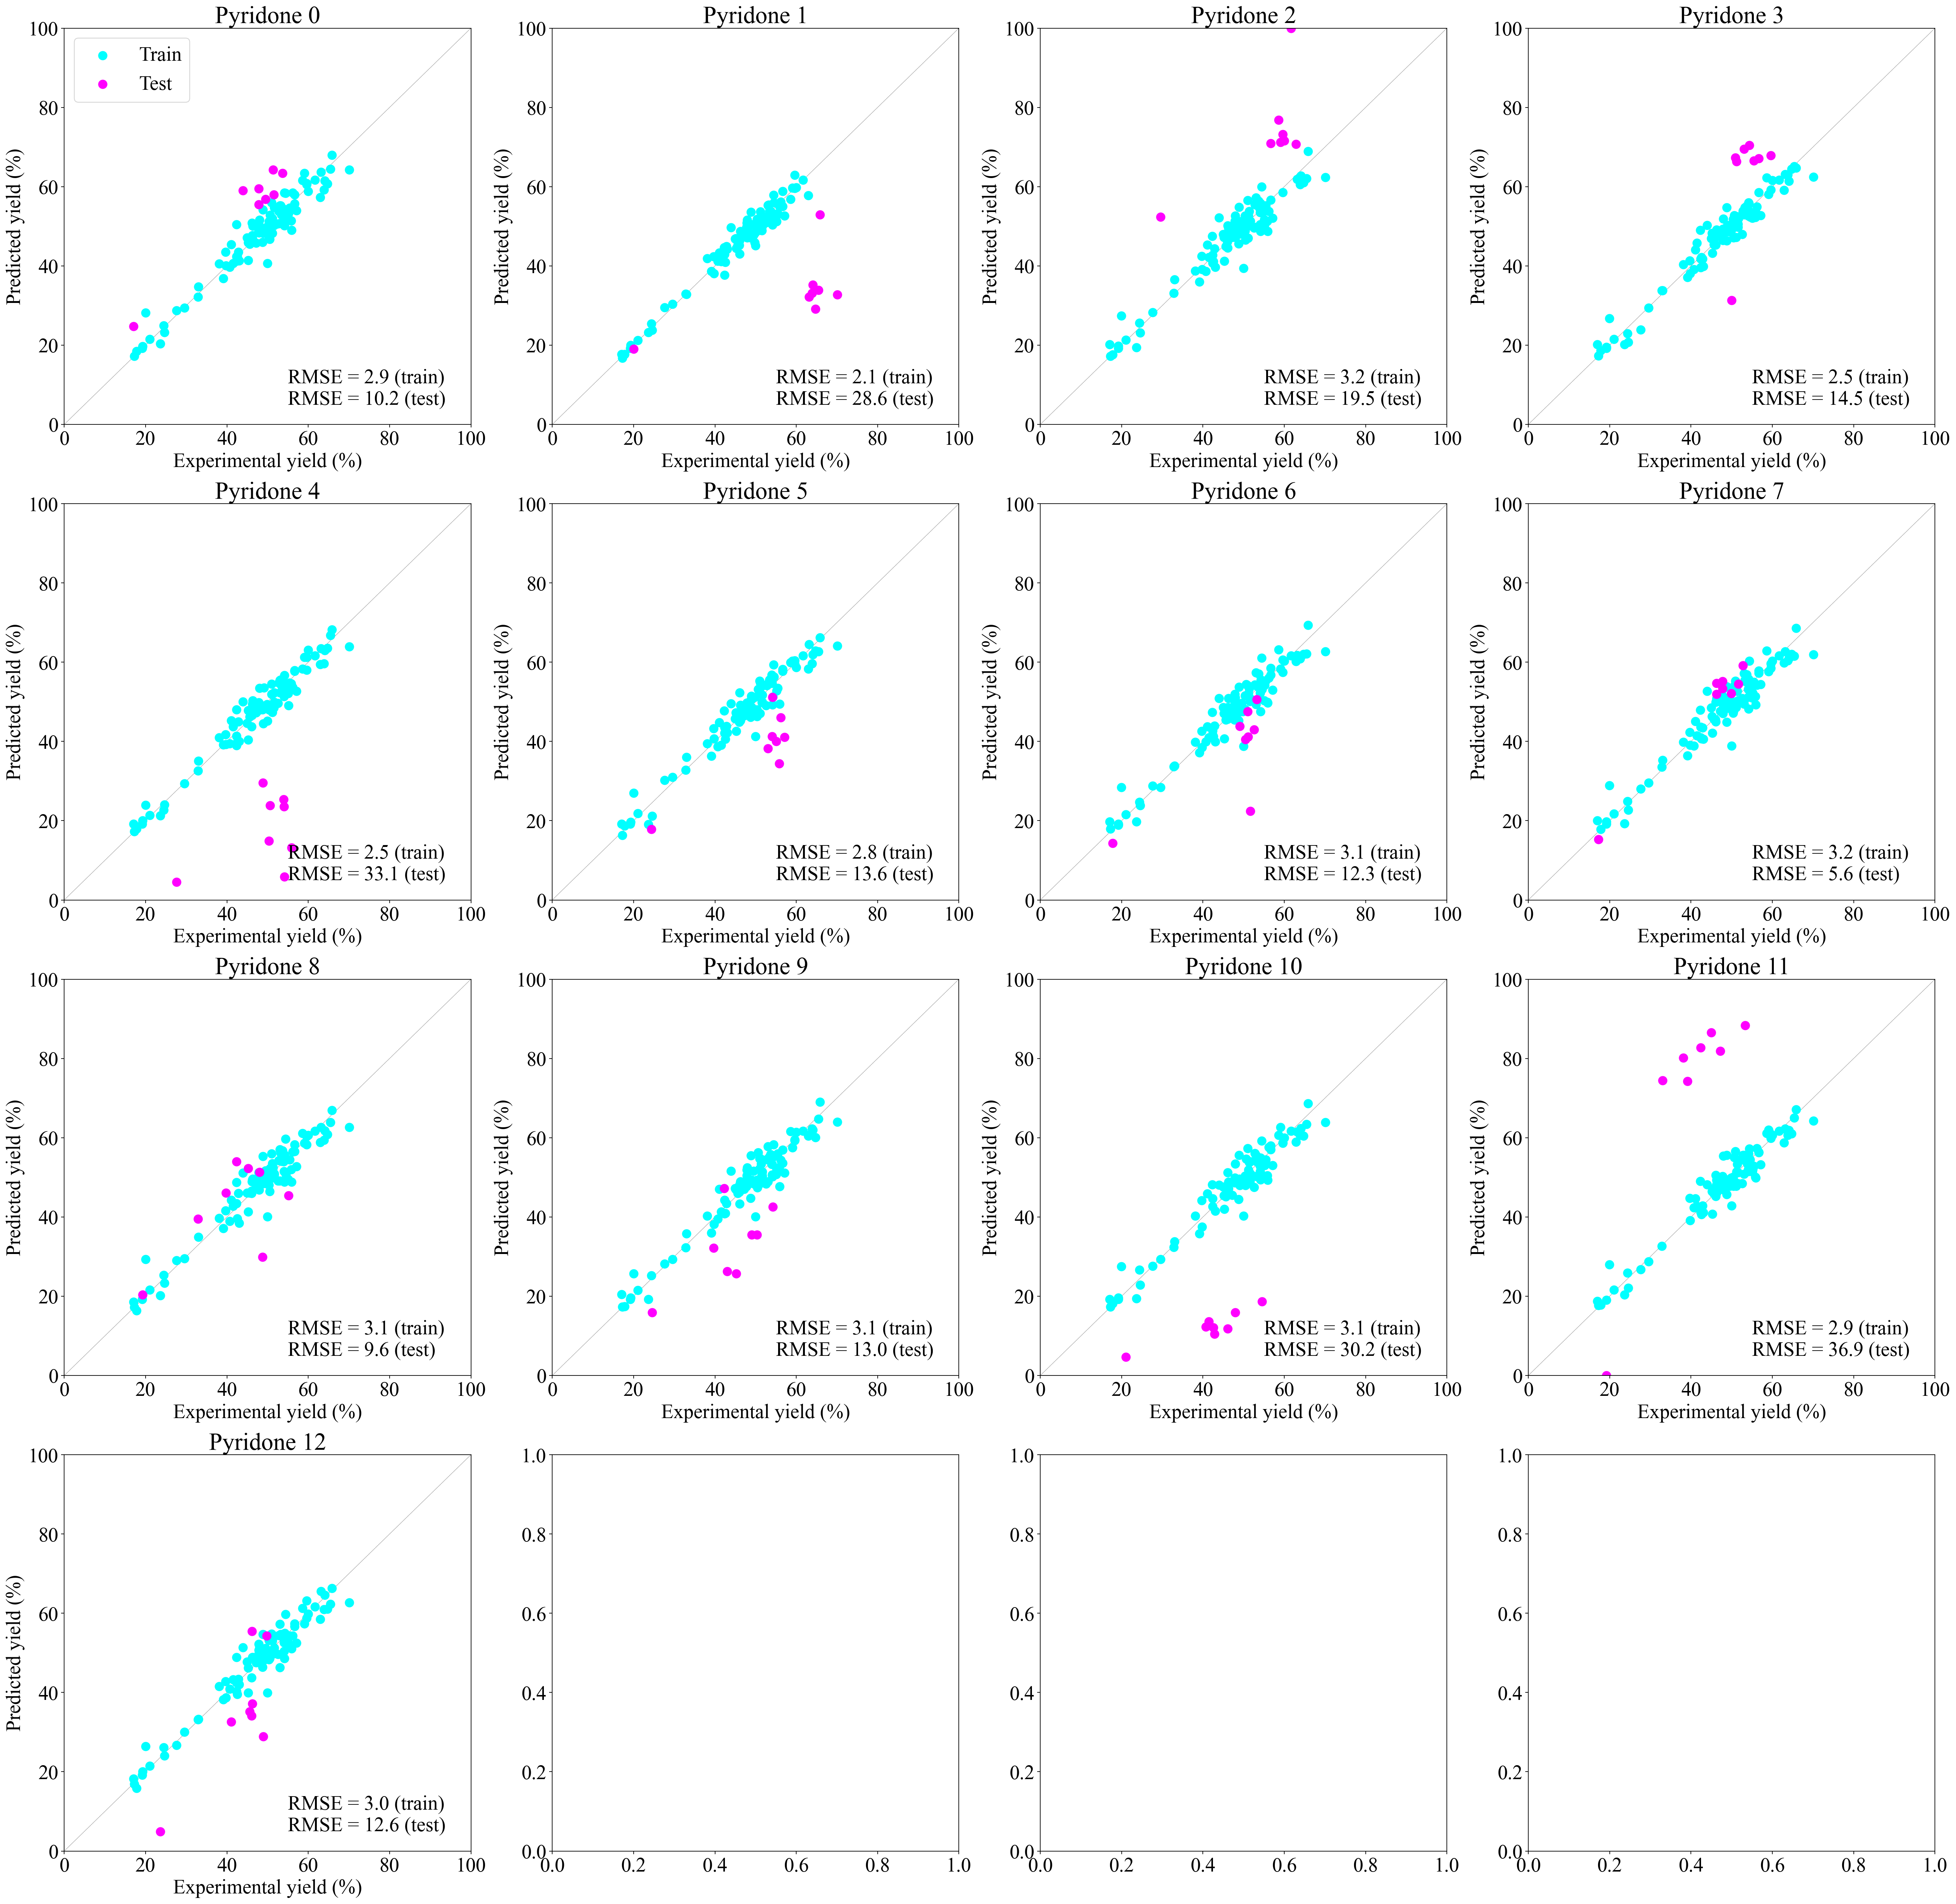

In [13]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(4, 4, figsize=(40, 40))

for i, (num, model) in enumerate(models_df[n_features_min].items()):
    div, mod = divmod(i, 4)
    axes[div, mod].set_title(f"Pyridone {num}")
    axes[div, mod].set_xlabel("Experimental yield (%)")
    axes[div, mod].set_ylabel("Predicted yield (%)")
    axes[div, mod].plot(
        [0, 100], [0, 100],
        color="black", linewidth=0.5, linestyle="dotted", zorder=0
    )
    axes[div, mod].scatter(
        model.y_train, model.y_pred_train,
        color="cyan", s=100, label="Train", zorder=1
    )
    axes[div, mod].scatter(
        model.y_test, model.y_pred_test,
        color="magenta", s=100, label="Test", zorder=2
    )
    axes[div, mod].text(
        55, 5,
        f"RMSE = {mean_squared_error(model.y_train, model.y_pred_train, squared=False):1.1f} (train)\n"
        f"RMSE = {mean_squared_error(model.y_test, model.y_pred_test, squared=False):1.1f} (test)"
    )
    axes[div, mod].set_xlim(0, 100)
    axes[div, mod].set_ylim(0, 100)
    if i == 0:
        axes[div, mod].legend()
    
plt.savefig("./OLS_RFE_zero_scatter_each.png")
plt.show()


In [14]:
coef_dfs = []

for num, model in models_df[n_features_min].items():
    coef_df = pd.DataFrame(model.model_.coef_.reshape(1, -1), index=[num], columns=model.X_train.columns)
    coef_dfs.append(coef_df)
    
coef_dfs_concat = pd.concat(coef_dfs, axis=0, join="outer")
coef_dfs_concat = coef_dfs_concat.reindex(columns=sorted(coef_dfs_concat.columns, key=int))
coef_dfs_concat = coef_dfs_concat.fillna(0)
coef_dfs_concat.loc["mean"] = coef_dfs_concat.mean()
display(coef_dfs_concat)


,2,3,4,6,7,9,12,14,16,18,...,507,519,538,540,543,575,597,602,605,642
0,2.843759,-0.660133,-4.030102,-0.484464,1.342656,-0.160728,0.485741,-1.581460,-0.069301,-0.080161,...,6.203681,-0.223611,0.109746,-2.088055,0.306350,-0.142990,1.404438,0.897628,1.055810,0.192108
1,8.661002,-0.844047,-7.411044,0.762152,0.418647,-1.941567,0.823612,-0.440915,-1.685953,-0.091974,...,4.054500,-1.858096,0.255176,-1.734065,0.164376,-0.387046,0.332031,0.079934,1.000356,-0.286568
2,10.650731,0.182984,-11.215143,0.109834,1.019496,-2.275632,0.567576,-0.028185,-618.154096,-0.185622,...,5.341151,-0.711952,-0.199777,-2.767309,0.363813,0.327741,1.707366,1.322363,-0.388605,0.413435
3,2.523059,0.562005,-3.967647,-0.348972,1.802036,-0.717479,0.439138,-0.058383,-0.197004,-0.224545,...,-0.078433,-2.063755,-0.431941,-0.512574,-0.116783,0.659091,1.768239,0.465204,-0.623916,0.256777
4,10.254848,0.291592,-11.392926,0.528545,1.352431,-2.903166,0.784379,-0.193747,-1.345122,-0.079955,...,3.077933,0.400434,-0.173909,-4.067212,0.800844,0.014577,2.655807,1.898145,-2.215376,0.112237
5,-6.317677,-0.325521,5.022224,0.149142,0.123249,1.579255,-0.067236,-0.151879,0.382135,-0.094639,...,5.985043,-1.204275,-0.078555,-0.685955,0.223331,-0.266671,-0.628593,-1.186344,0.212630,0.660717
6,4.155486,-0.979606,-2.703021,-0.540354,1.147065,1.690351,0.196258,0.174191,0.187415,0.006260,...,0.603215,-2.510297,3.078260,1.232637,0.400669,-0.284462,0.790684,-0.922646,1.332948,-2.729781
7,9.987764,-0.134848,-9.338575,0.135110,1.043629,-0.674429,0.220315,0.702498,0.027831,-0.141004,...,1.486030,-1.763635,0.184015,-1.762158,0.321995,0.387419,0.842711,0.759737,0.042699,0.124671
8,39.069392,0.840838,-39.053558,0.291796,2.399890,-0.879032,0.425991,0.010129,-0.424419,-0.364609,...,4.802061,1.621866,-0.217299,-4.318656,0.177926,0.803566,1.259921,-2.563193,0.949755,0.349698
9,19.107338,-0.508000,-18.458912,-0.315752,1.880891,-2.220024,0.394565,-0.084953,-0.108298,0.066046,...,3.421093,1.440978,-0.207488,-3.035688,0.059603,-0.107947,0.639608,0.256116,0.496370,-0.222527


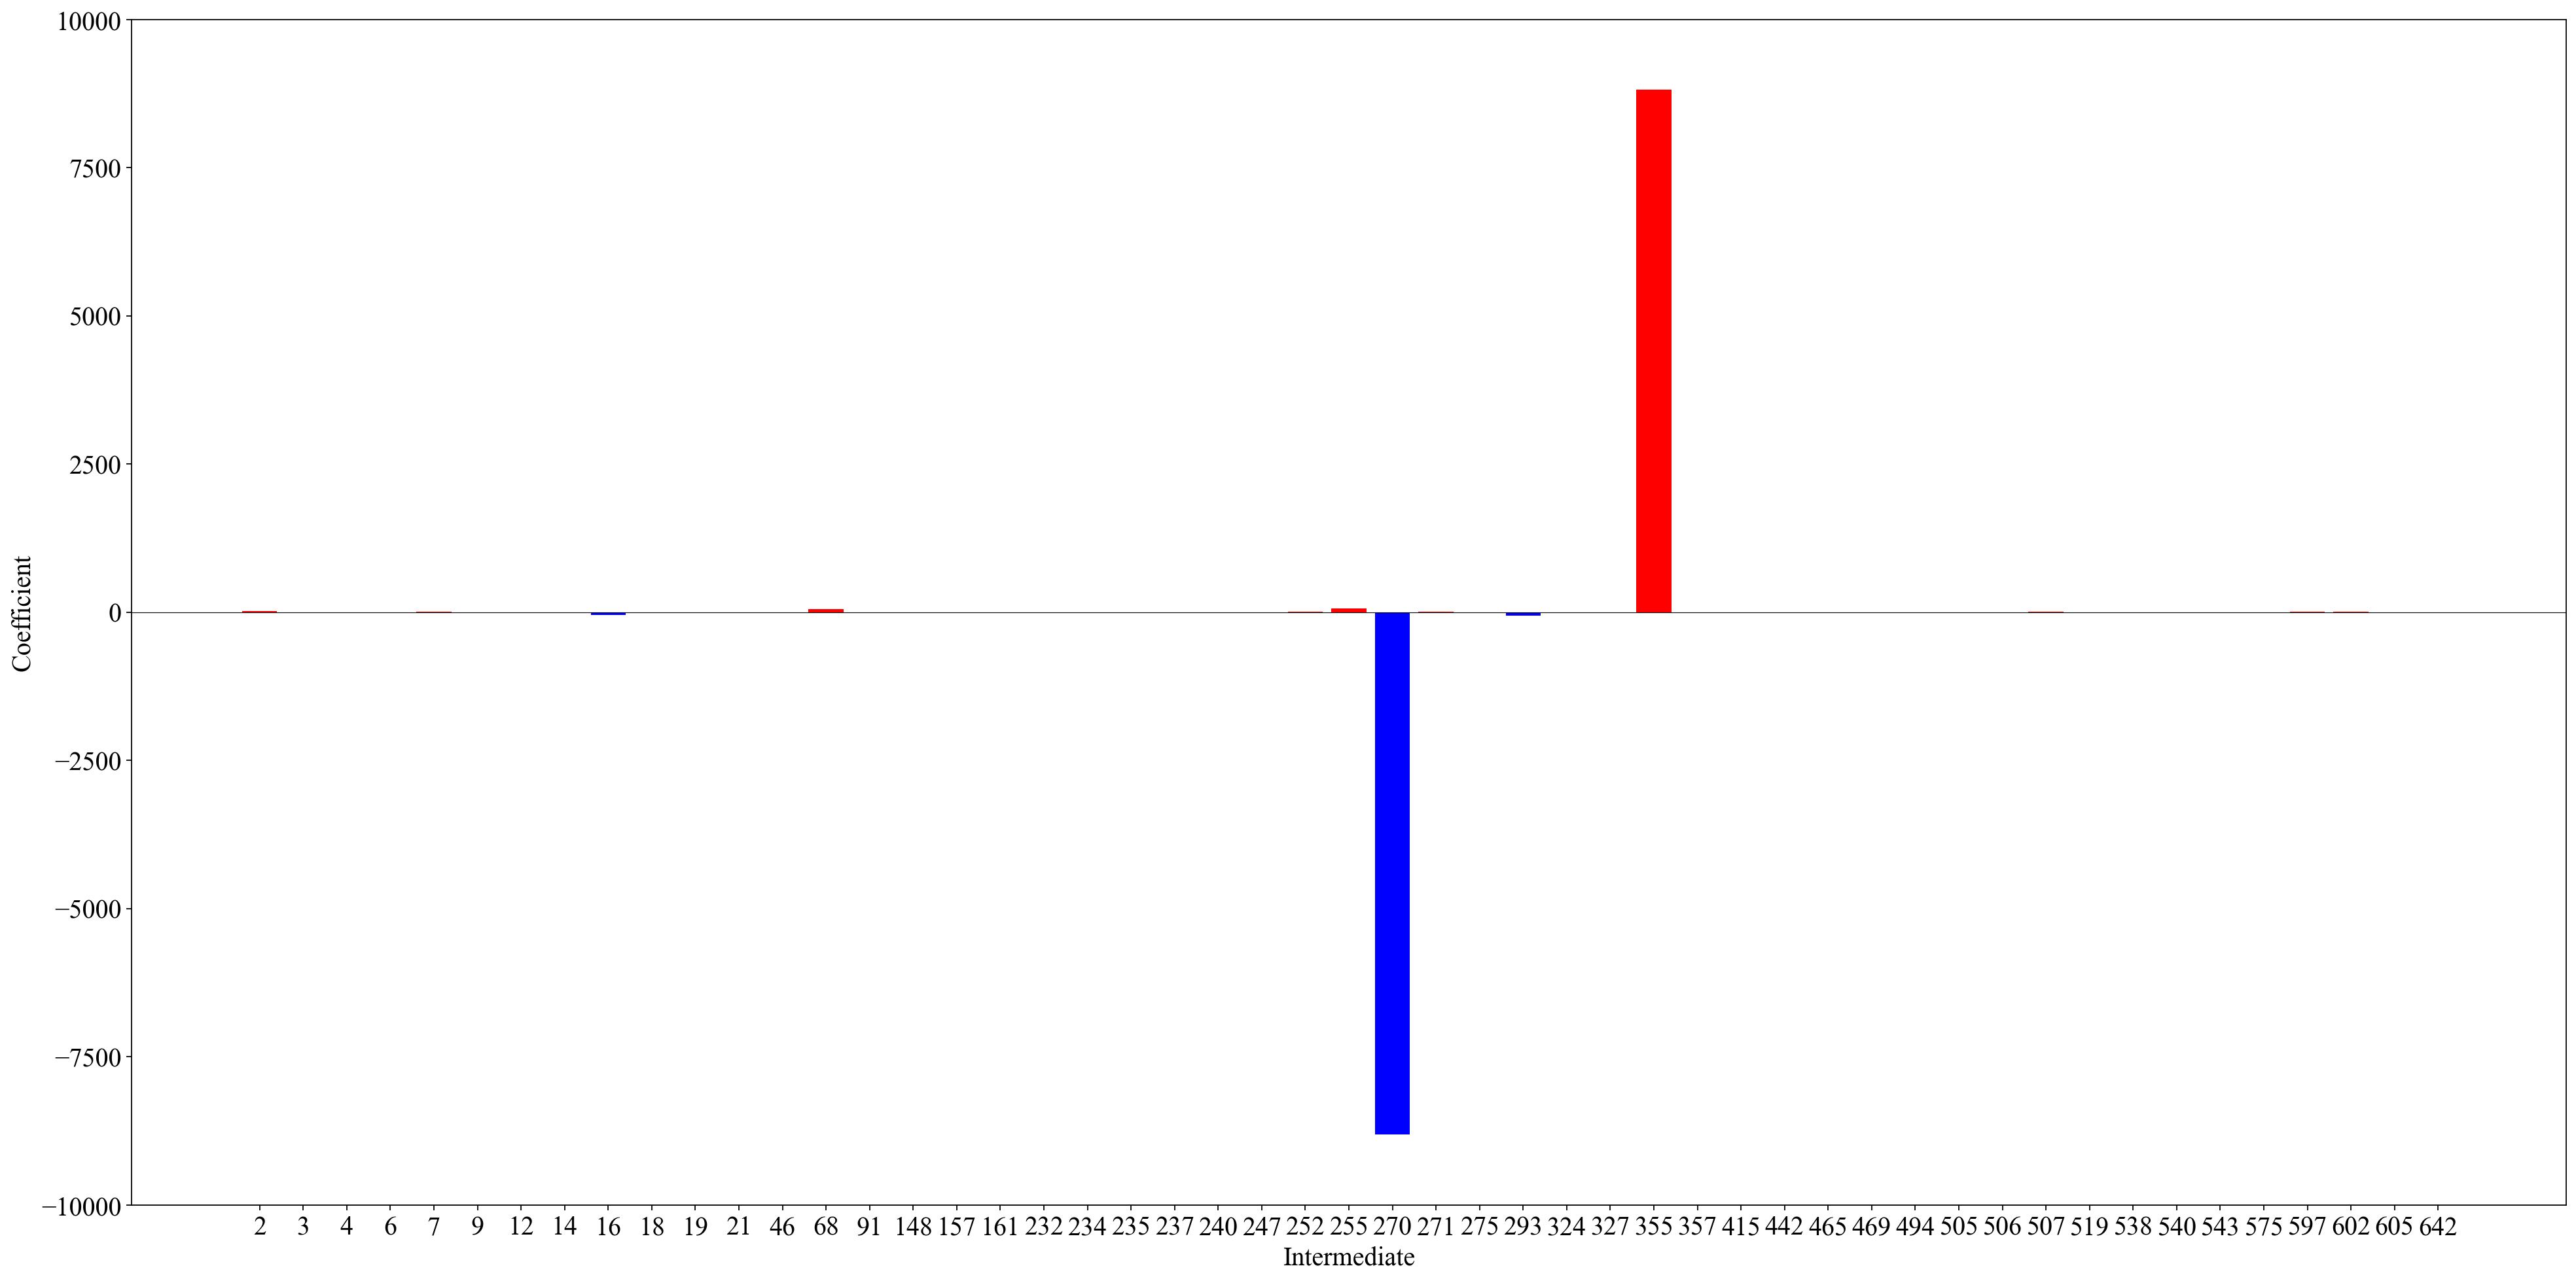

In [15]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.set_xlabel("Intermediate")
ax.set_ylabel("Coefficient")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]>0), color="red")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]<0), color="blue")
ax.axhline(y=0.0, linewidth=0.5, color="black")
ax.set_ylim(-10000, 10000)
plt.savefig("./OLS_RFE_zero_coefficient.png")
plt.show()


In [ ]:
# multicollinearity problem